<h4><b>Importing necessary libraries and connecting to the database</b></h4>

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Connect to SQLite database
conn = sqlite3.connect("../saas.db")

<h4><b>Loading account lifecycle data for acquisition cohort analysis</b></h4>

In [ ]:
account_lifecycle=pd.read_sql("SELECT a.account_id, a.signup_date,MIN(c.churn_date) AS churn_date FROM accounts a LEFT JOIN churn c ON a.account_id = c.account_id GROUP BY a.account_id, a.signup_date ",conn)
account_lifecycle["signup_month"] = pd.to_datetime(account_lifecycle["signup_date"]).dt.to_period("M").dt.to_timestamp()
account_lifecycle["cohort_month"] = account_lifecycle["signup_month"].dt.strftime("%Y-%m")
account_lifecycle["churn_date"]=pd.to_datetime(account_lifecycle["churn_date"])
account_lifecycle.head()

,account_id,signup_date,churn_date,signup_month,cohort_month
0,A-00bed1,2023-11-14,2024-01-03,2023-11-01,2023-11
1,A-00cac8,2023-09-15,NaT,2023-09-01,2023-09
2,A-0158bb,2024-05-22,NaT,2024-05-01,2024-05
3,A-016043,2024-07-31,2024-08-11,2024-07-01,2024-07
4,A-019782,2023-04-19,NaT,2023-04-01,2023-04


Note: *Churn Date is the first churn date*

<h4><b>Calculating Retention Table</b></h4>

In [ ]:
 #creating list of all months within the possible range
analysis_months = pd.date_range(start=account_lifecycle["signup_month"].min() , end= account_lifecycle["churn_date"].max(),freq="MS")
account_lifecycle["key"] = 1 #creating a key to merge analysis_calendar on 
calendar_m = pd.DataFrame({"analysis_month": analysis_months, "key": 1}) #converting analysis months to dataframe to merge
account_lifecycle_expanded= account_lifecycle.merge(calendar_m, on="key").drop("key",axis=1) # merging the analysis months with the lifecycle
#putting condition so that only valid analysis months are in the dataset
account_lifecycle_expanded=account_lifecycle_expanded[account_lifecycle_expanded["analysis_month"]>=account_lifecycle_expanded["signup_month"]] 
#Calculating months since signup till analysis month
account_lifecycle_expanded["months_since_signup"] = (
    (account_lifecycle_expanded["analysis_month"].dt.year - account_lifecycle_expanded["signup_month"].dt.year) * 12
    + (account_lifecycle_expanded["analysis_month"].dt.month - account_lifecycle_expanded["signup_month"].dt.month)
)
account_lifecycle_expanded["is_retained"] = (account_lifecycle_expanded["churn_date"].isna() | (account_lifecycle_expanded["churn_date"] >= account_lifecycle_expanded["analysis_month"] + pd.offsets.MonthEnd(0))
).astype(int)  #creating is retained column which 1 if account is retained by the analysis month and 0 if its not
#Calculating Retention Table 
retention_table = account_lifecycle_expanded.groupby(["cohort_month","months_since_signup"])["is_retained"].mean().reset_index(name="retention_rate")
cohort_retention_matrix = retention_table.pivot(
    index="cohort_month",
    columns="months_since_signup",
    values="retention_rate"
)

,cohort_month,months_since_signup,retention_rate
0,2023-01,0,0.941176
1,2023-01,1,0.941176
2,2023-01,2,0.941176
3,2023-01,3,0.882353
4,2023-01,4,0.764706


<h4><b>Plotting the Retention matrix as a Heatmap</b></h4>

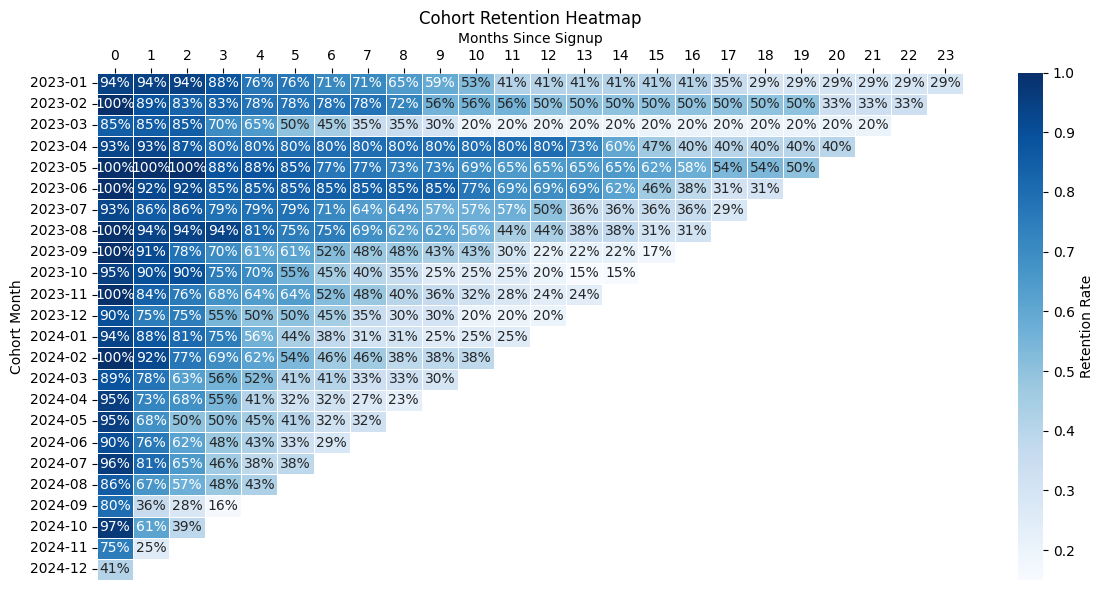

In [ ]:
plt.figure(figsize=(12, 6))

fig=sns.heatmap(
    cohort_retention_matrix,
    annot=True,
    fmt=".0%",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={"label": "Retention Rate"}
)

plt.title("Cohort Retention Heatmap")
plt.xlabel("Months Since Signup")
plt.ylabel("Cohort Month")
fig.xaxis.tick_top()
fig.xaxis.set_label_position("top")
plt.tight_layout()
plt.show()

<h4><b> Plotting 3 retention curves from different periods in the data to see the general trend of retention</b></h4>

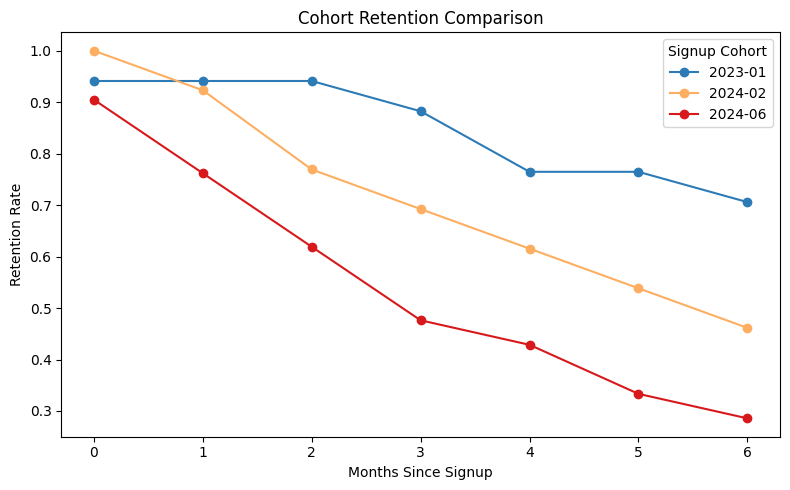

In [ ]:
# cohorts to be plotted
selected_cohorts = ["2023-01", "2024-02", "2024-06"]

# limiting analysis month till 6
max_month = 6

plt.figure(figsize=(8, 5))
colors = {
    "2023-01": "#2c7bb6",  # blue for reference
    "2024-02": "#fdae61",  # orange  for deterioration start
    "2024-06": "#d7191c",  # red for progressive deterioration
}
for cohort in selected_cohorts:
    y = cohort_retention_matrix.loc[cohort, :max_month]
    x = y.index
    plt.plot(x, y, marker="o",color=colors[cohort], label=cohort)

plt.xlabel("Months Since Signup")
plt.ylabel("Retention Rate")
plt.title("Cohort Retention Comparison")
plt.legend(title="Signup Cohort")

plt.tight_layout()
plt.show()

<h5>Cohort-level heatmaps and retention curves show that customers acquired in 2024 are churning earlier in their lifecycle compared to previous cohorts. The most pronounced differences emerge within the first one to three months after signup, helping explain both the surge in monthly churn and the flattening of the active account base(EDA).</h5>

<h4><b>Creating Trial Cohort and Non-Trial Cohort</b></h4>

In [ ]:
is_trial=pd.read_sql("SELECT account_id, is_trial FROM accounts",conn)
is_trial["is_trial"] = is_trial["is_trial"]=='True'
acc_lifecycle_exp_trial = account_lifecycle_expanded.merge(is_trial,on="account_id")
acc_lifecycle_exp_trial.head()


,account_id,signup_date,churn_date,signup_month,cohort_month,analysis_month,months_since_signup,is_retained,is_trial
0,A-00bed1,2023-11-14,2024-01-03,2023-11-01,2023-11,2023-11-01,0,1,True
1,A-00bed1,2023-11-14,2024-01-03,2023-11-01,2023-11,2023-12-01,1,1,True
2,A-00bed1,2023-11-14,2024-01-03,2023-11-01,2023-11,2024-01-01,2,0,True
3,A-00bed1,2023-11-14,2024-01-03,2023-11-01,2023-11,2024-02-01,3,0,True
4,A-00bed1,2023-11-14,2024-01-03,2023-11-01,2023-11,2024-03-01,4,0,True


In [ ]:
retention_table_trial = acc_lifecycle_exp_trial[acc_lifecycle_exp_trial["is_trial"]==True].groupby(["cohort_month","months_since_signup"])["is_retained"].mean().reset_index(name="retention_rate")
retention_table_ntrial = acc_lifecycle_exp_trial[acc_lifecycle_exp_trial["is_trial"]==False].groupby(["cohort_month","months_since_signup"])["is_retained"].mean().reset_index(name="retention_rate")
cohort_retention_matrix_trial = retention_table_trial.pivot(
    index="cohort_month",
    columns="months_since_signup",
    values="retention_rate"
)
cohort_retention_matrix_ntrial = retention_table_ntrial.pivot(
    index="cohort_month",
    columns="months_since_signup",
    values="retention_rate"
)

<h4><b>Plotting Trial Cohort as a Heatmap</b></h4>

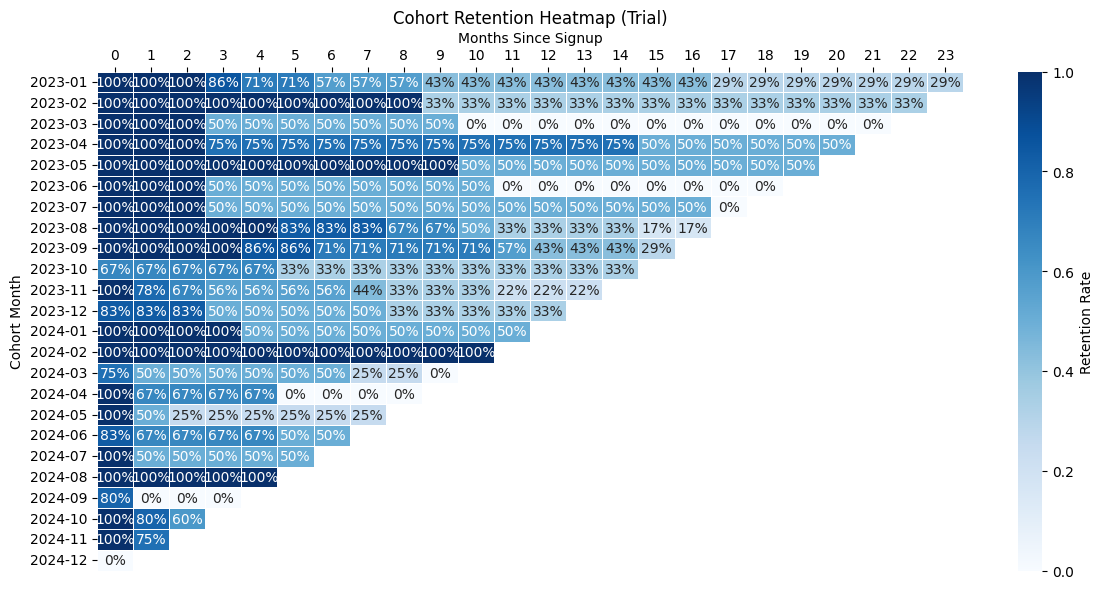

In [ ]:
plt.figure(figsize=(12, 6))

fig=sns.heatmap(
    cohort_retention_matrix_trial,
    annot=True,
    fmt=".0%",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={"label": "Retention Rate"}
)

plt.title("Cohort Retention Heatmap (Trial)")
plt.xlabel("Months Since Signup")
plt.ylabel("Cohort Month")
fig.xaxis.tick_top()
fig.xaxis.set_label_position("top")
plt.tight_layout()
plt.show()

<h4><b>Plotting Non-Trial Cohort as a Heatmap</b></h4>

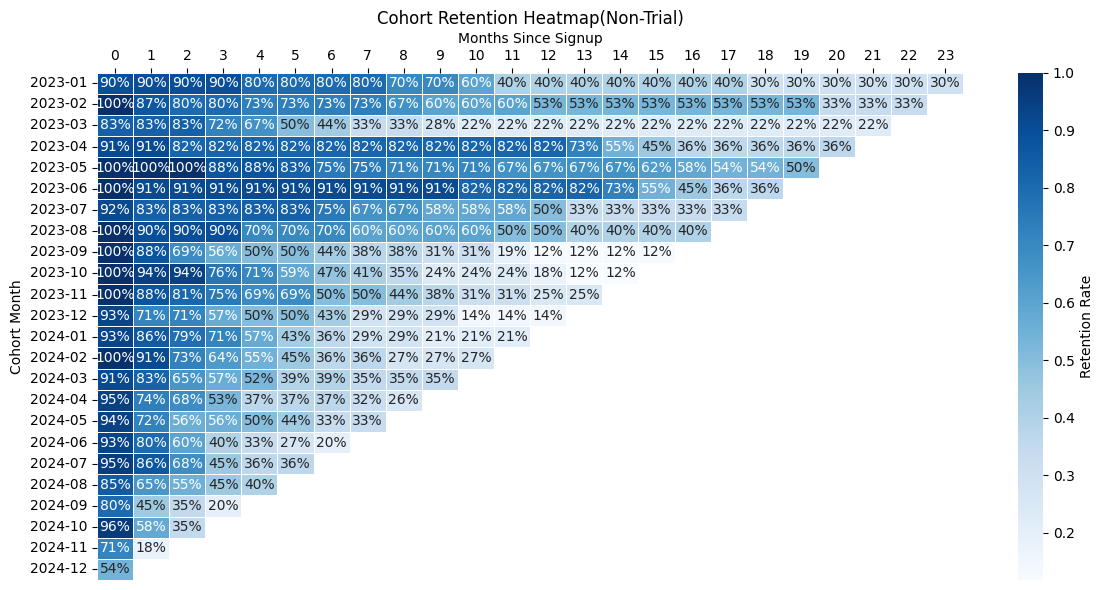

In [ ]:
plt.figure(figsize=(12, 6))

fig=sns.heatmap(
    cohort_retention_matrix_ntrial,
    annot=True,
    fmt=".0%",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={"label": "Retention Rate"}
)

plt.title("Cohort Retention Heatmap(Non-Trial)")
plt.xlabel("Months Since Signup")
plt.ylabel("Cohort Month")
fig.xaxis.tick_top()
fig.xaxis.set_label_position("top")
plt.tight_layout()
plt.show()

## Conclusion
- Splitting signup-month cohorts by trial status reveals that the churn spike observed in 2024 is primarily driven by trial users exhibiting severe early-life churn within the first 1–3 months after signup.
- While non-trial cohorts also show some deterioration, their retention decay is more gradual. This indicates that the churn increase is largely an onboarding and early activation problem rather than a broad customer value issue.

In [7]:
retention_table.to_csv("../data/processed/retention_table.csv",index=False)